In [1]:
from keras.models import Model
import keras.models
import keras.layers as layers
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from keras.utils import np_utils
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score
from keras import backend as K

import argparse
import cnn_analyzer as cnna
import cnn_builder as cbuild
import cnn_runner as crun
import config
import csv
import niftiutils.helper_fxns as hf
import importlib
import inference_methods as im
import itertools
from math import sqrt, log, pi, exp
import matplotlib.pyplot as plt
from numba import jit, njit, prange, vectorize, guvectorize
from numpy import matmul, diag
import numpy as np
import operator
import os
import pandas as pd
import random
import scipy
import time
%matplotlib inline

C:\Users\Clinton\AppData\Local\conda\conda\envs\old-keras\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
importlib.reload(config)
importlib.reload(hf)
importlib.reload(cbuild)
importlib.reload(crun)
C = config.Config()
T = config.Hyperparams()
#T.steps_per_epoch = 50
#T.epochs= 1
#T.get_best_hyperparams()

In [ ]:
crun.run_fixed_hyperparams([C], hyperparams=T)#C_list)

In [ ]:
model = cbuild.build_cnn_hyperparams(T)
model.summary(line_length=150)

In [68]:
Z_reader = ['E103312835_1','12823036_0','12569915_0','E102093118_0','E102782525_0','12799652_0','E100894274_0','12874178_3','E100314676_0','12842070_0','13092836_2','12239783_0','12783467_0','13092966_0','E100962970_0','E100183257_1','E102634440_0','E106182827_0','12582632_0','E100121654_0','E100407633_0','E105310461_0','12788616_0','E101225606_0','12678910_1','E101083458_1','12324408_0','13031955_0','E101415263_0','E103192914_0','12888679_2','E106096969_0','E100192709_1','13112385_1','E100718398_0','12207268_0','E105244287_0','E102095465_0','E102613189_0','12961059_0','11907521_0','E105311123_0','12552705_0','E100610622_0','12975280_0','E105918926_0','E103020139_1','E101069048_1','E105427046_0','13028374_0','E100262351_0','12302576_0','12451831_0','E102929168_0','E100383453_0','E105344747_0','12569826_0','E100168661_0','12530153_0','E104697262_0']
X_test, Y_test, train_generator, num_samples, train_orig, Z = cbuild.get_cnn_data(n=4, n_art=0)#, Z_test_fixed=Z_reader)
Z_test, Z_train_orig = Z
X_train_orig, Y_train_orig = train_orig

In [59]:
#from keras.utils import multi_gpu_model
#model = multi_gpu_model(model, gpus=2)

In [ ]:
hist = model.fit_generator(train_generator, steps_per_epoch=T.steps_per_epoch, epochs=T.epochs, validation_data=[X_test, Y_test])#, callbacks=[T.early_stopping])

In [71]:
model.save('E:\\models\\model_reader_rcnn.hdf5')

In [12]:
import dr_methods as drm
voi_df_art, voi_df_ven, voi_df_eq = drm.get_voi_dfs()
small_voi_df = pd.read_csv(C.small_voi_path)

In [ ]:
#plot_with_bbox(fn_list[2], cls_mapping[wrong_guesses[2]])
Y_pred = model.predict(X_test)
y_true = np.array([max(enumerate(x), key=operator.itemgetter(1))[0] for x in Y_test])
y_pred = np.array([max(enumerate(x), key=operator.itemgetter(1))[0] for x in Y_pred])

cm = confusion_matrix(y_true, y_pred)
f1 = f1_score(y_true, y_pred, average="weighted")

#save_output(Z_test, y_pred, y_true)

print(accuracy_score(y_true, y_pred))
#y_true_simp, y_pred_simp, _ = cnna.merge_classes(y_true, y_pred)
#print(accuracy_score(y_true_simp, y_pred_simp))

In [3]:
model = keras.models.load_model(os.path.join(C.model_dir, "models_305.hdf5")) #models_305

In [344]:
importlib.reload(cbuild)

<module 'cnn_builder' from 'C:\\Users\\Clinton\\Documents\\voi-classifier\\python\\cnn_builder.py'>

In [312]:
X_test, Y_test, train_generator, num_samples, train_orig, Z = cbuild.get_cnn_data(n=4, n_art=0, Z_test=Z_reader)
Z_test, Z_train_orig = Z
Y_pred = model.predict(X_test)
y_true = np.array([max(enumerate(x), key=operator.itemgetter(1))[0] for x in Y_test])
y_pred = np.array([max(enumerate(x), key=operator.itemgetter(1))[0] for x in Y_pred])
y_true_simp, y_pred_simp, _ = cbuild.merge_classes(y_true, y_pred)

In [42]:
Y_pred = [C.classes_to_include[y] for y in y_pred]
Y_true = [C.classes_to_include[y] for y in y_true]

In [43]:
a = pd.DataFrame([Z_test,Y_pred,Y_true])

In [45]:
a.to_csv('E:\\temp.csv')

In [205]:
acc6cls = []
acc3cls = []

for i in range(19):
    model_num = 306+i
    X_test, Y_test, train_generator, num_samples, train_orig, Z = cbuild.get_cnn_data(n=4, n_art=0, Z_test=df[df['model_num'] == model_num]["z_test"])
    X_train_orig, Y_train_orig = train_orig
    model = keras.models.load_model(os.path.join(C.model_dir, "models_%d.hdf5" % model_num)) #models_305
    
    Y_pred = model.predict(X_train_orig)
    y_true = np.array([max(enumerate(x), key=operator.itemgetter(1))[0] for x in Y_train_orig])
    y_pred = np.array([max(enumerate(x), key=operator.itemgetter(1))[0] for x in Y_pred])

    acc6cls.append(accuracy_score(y_true, y_pred))

    y_true_simp, y_pred_simp, _ = cbuild.merge_classes(y_true, y_pred)

    acc3cls.append(accuracy_score(y_true_simp, y_pred_simp))

In [22]:
df = pd.read_excel("Z:\\Inter-reader study\\Answer key.xlsx")

In [23]:
y_true = df["Class"].values
y_pred = df["Model"].values

In [24]:
cm = confusion_matrix(y_true, y_pred, labels=C.classes_to_include)

In [46]:
for i in range(len(cm)):
    print('\t'.join(cm[:,i].astype(str)))

10	0	1	0	0	1
0	9	1	0	0	0
0	1	8	0	0	0
0	0	0	10	0	0
0	0	0	0	9	0
0	0	0	0	1	9


In [72]:
fn_list = fn_list + list(Z_test[~np.equal(y_pred, y_true)])

In [74]:
fn_list = fn_list + list(Z_train_orig[~np.equal(y_pred, y_true)])
fn_list = fn_list + list(Z_train_orig[~np.equal(y_pred, y_true)])

In [75]:
fn_x_list = [x+"("+str(voi_df_art[voi_df_art["id"] == x[:-4]]["x1"].values[0])+")" for x in fn_list]

In [76]:
unique, counts = np.unique(fn_x_list, return_counts=True)

In [ ]:
dict(zip(unique, counts))

In [195]:
Y_pred = model.predict(X_train_orig)
y_true = np.array([max(enumerate(x), key=operator.itemgetter(1))[0] for x in Y_train_orig])
y_pred = np.array([max(enumerate(x), key=operator.itemgetter(1))[0] for x in Y_pred])

cm = confusion_matrix(y_true, y_pred)
f1 = f1_score(y_true, y_pred, average="weighted")

#cbuild.save_output(Z_train_orig, y_pred, y_true)#, save_dir=C.output_img_dir+"\\training")

In [6]:
importlib.reload(cbuild)

<module 'cnn_builder' from 'C:\\Users\\Clinton\\Documents\\voi-classifier\\python\\cnn_builder.py'>

In [ ]:
model_dropout = cbuild.build_model_forced_dropout(model, )

In [ ]:
#cnna.visualize_layer(model, 'conv3d_148')


In [5]:
orig_data_dict, num_samples = cbuild._collect_unaug_data()
filters_by_cls = {cls: model_dense_outputs.predict(orig_data_dict[cls][0], verbose=False) for cls in C.classes_to_include}
fig = cnna.tsne(filters_by_cls)
fig.show()

In [224]:
len(hf.flatten([list(feature_sheet["evidence1"+cls].dropna().values) for cls in C.classes_to_include]))

137

In [53]:
importlib.reload(cbuild)
C=config.Config()

In [54]:
model = keras.models.load_model(os.path.join(C.model_dir, "models_305.hdf5")) #models_305
model_dense_outputs = cbuild.build_pretrain_model(model)

In [55]:
orig_data_dict, num_samples = cbuild._collect_unaug_data()
filters_by_cls = {cls: model_dense_outputs.predict(orig_data_dict[cls][0], verbose=False) for cls in C.classes_to_include}
filter_results = np.concatenate([filters_by_cls[cls] for cls in C.classes_to_include], axis=0)

filter_avgs = np.mean(filter_results, axis=0)
filter_stds = np.std(filter_results, axis=0)

#filter_cls_avg_unscaled = {cls: np.mean(filter_results[cls], axis=0) for cls in C.classes_to_include}
#filter_cls_avg_scaled = {cls: np.mean(filter_results[cls], axis=0) / filter_avgs for cls in C.classes_to_include}

features_by_cls, feat_count = cnna.collect_features()
all_features = list(feat_count.keys())
cls_features = {f: [c for c in C.classes_to_include if f in features_by_cls[c]] for f in all_features}

z = dict(zip(*np.unique(features_by_cls['colorectal'], return_counts=True)))
for k in z:
    print(k, " (",z[k],")", sep="")

feat_count

In [56]:
Z_features = cnna.get_annotated_files(features_by_cls)

feature_filter_means = {}
feature_filter_stds = {}
feature_filters_scaled = {}#{cls: {} for cls in features}
feature_filters = {f:np.empty([0,100]) for f in all_features}

for f in all_features:
    for cls in C.classes_to_include:
        x_features = orig_data_dict[cls][0][np.where(np.isin(orig_data_dict[cls][1], Z_features[f]))]
        if x_features.size > 0:
            feature_filters[f] = np.concatenate([feature_filters[f], model_dense_outputs.predict(x_features, verbose=False)], axis=0)# / filter_avgs
        
    feature_filters[f] = (feature_filters[f] - filter_avgs) / filter_stds
    
    feature_filter_means[f] = np.mean(feature_filters[f], axis=0)# / filter_avgs
    feature_filter_stds[f] = np.std(feature_filters[f], axis=0)# / filter_avgs

    #ff = feature_filters[f]
    #feature_filters[f] = np.where(ff > np.mean(ff), ff, 0)

    #ff = feature_filters[cls][f]
    #feature_filters[cls][f] = np.where(ff > 1*filter_cls_avg_unscaled[cls], ff, 0)

    #ff = feature_filters[f]
    #feature_filters[f] = np.where(ff > 1.3*filter_avgs, ff, 0)

    feature_filters_scaled[f] = feature_filter_means[f] / filter_avgs

In [57]:
num_features = len(all_features) # number of features
num_units = 100 # number of dense units

num_annotations = 5
Z_test = ['E106097391_0', 'E104978772_1', '12900535_0', 'E100150242_0', 'E105490014_0', 'E103147618_0', 'E103510187_0', 'E104657225_0', 'E100551966_0', 'E101388602_0', 'E100215900_8', 'E100215900_7', 'E104045692_0', '13104521_0', 'E100383453_0', '12943286_0', '12271995_0', 'E102315724_0', 'E104949189_0', 'E100511083_1', 'E101579471_0', '13018986_1', '13203550_8', '13112385_0', '12712463_0', '12361082_0', '13028374_0', 'E103985934_1', 'E100529980_0', '12042703_3', '12961059_0', 'E105724706_2', 'E100592424_2', 'E103104254_0', 'E104546069_0', 'E101665217_1', '12090000_0', 'E100592424_1', '12961059_1', 'E105474285_0', '12502068_1', 'E100814791_0', 'E102613189_0', 'E105427046_0', 'E102881031_1', 'E102929168_0', 'E102310482_0', 'E102095465_0', 'E101811299_0', 'E104737273_0', '12890053_0', 'E100168661_1', '12637865_0', 'E100168661_2', '12239783_0', '12707781_0', '12706568_1', '12823036_0', '12404081_0', '12365693_1']

indices_f = [orig_data_dict[cls][1] for cls in C.classes_to_include]
indices_f = hf.flatten(indices_f)

fixed_indices = np.empty([num_features, num_annotations])
for f_ix,f in enumerate(all_features):
    fixed_indices[f_ix, :] = np.where(np.isin(indices_f, random.sample(set(Z_features[f]), num_annotations)))[0]
fixed_indices = fixed_indices.astype(int)

test_indices = np.where(np.isin(indices_f, Z_test))[0]

z_states = np.array([z for z in itertools.product([0,1], repeat=num_features) if sum(z) <= 4 and sum(z) >= 2])
num_states = len(z_states)
num_imgs = filter_results.shape[0]
z_states_bool = [tuple([bool(x) for x in z]) for z in z_states]

In [98]:
def EM_theta(k, k2=None, alpha=.5, beta=.5, **kwargs):
    if len(kwargs) == 0:
        mu = np.empty([num_features, num_units])
        sigma = np.empty([num_features, num_units])
        for i in range(num_features):
            mu[i] = feature_filter_means[all_features[i]]
            sigma[i] = feature_filter_stds[all_features[i]]
        sigma[sigma > 1] = 1
        m = filter_avgs
        s = filter_stds

        theta_i = scipy.random.normal(size=num_features)
        theta_ij = scipy.random.normal(size=[num_features-1, num_features])
    else:
        mu = kwargs['mu']
        sigma = kwargs['sigma']
        m = kwargs['m']
        s = kwargs['s']
        theta_i = kwargs['theta_i']
        theta_ij = kwargs['theta_ij']
    
    print("Initializing probabilities...")
    p_x_z = im.get_all_p_x_z(mu, m, sigma, s, z_states, filter_results, fixed_indices)
    p_z = im.get_p_z(z_states, theta_i, theta_ij)
    p_z_x = im.get_all_p_z_x(p_x_z, p_z)
    
    print("Running EM...")
    if k2 is None:
        for jj in range(k):
            print("   ", jj, end="...Update thetas...")
            theta_i, theta_ij = im.update_thetas(np.sum(p_z_x, axis=0), z_states_bool, theta_i, theta_ij, alpha)

            p_z = im.get_p_z(z_states, theta_i, theta_ij)
            p_z_x = im.get_all_p_z_x(p_x_z, p_z)

            print("Update means and stdevs...", end="")
            mu_est = im.update_mus(mu, m, sigma, s, z_states, filter_results, p_z_x, beta)
            m_est = im.update_ms(mu, m, sigma, s, z_states, filter_results, p_z_x, beta)
            sigma, s = im.update_stdevs_approx(mu, m, sigma, s, z_states, filter_results, p_z_x, beta)

            print("Update probabilities...")
            p_x_z = im.get_all_p_x_z(mu, m, sigma, s, z_states, filter_results, fixed_indices)
            p_z_x = im.get_all_p_z_x(p_x_z, p_z)
    
    else:
        for kk in range(k2):
            print(kk, "=======")
            for jj in range(k):
                print("   ", jj)
                theta_i, theta_ij = im.update_thetas(np.sum(p_z_x, axis=0), z_states_bool, theta_i, theta_ij, alpha)

                p_z = im.get_p_z(z_states, theta_i, theta_ij)
                p_z_x = im.get_all_p_z_x(p_x_z, p_z)

                mu_est = im.update_mus(mu, m, sigma, s, z_states, filter_results, p_z_x, beta)
                m_est = im.update_ms(mu, m, sigma, s, z_states, filter_results, p_z_x, beta)

                p_x_z = im.get_all_p_x_z(mu, m, sigma, s, z_states, filter_results, fixed_indices)
                p_z_x = im.get_all_p_z_x(p_x_z, p_z)

            print("Updating stdev...")
            sigma, s = im.update_stdevs_approx(mu, m, sigma, s, z_states, filter_results, p_z_x)

            if kk != k2-1:
                p_x_z = im.get_all_p_x_z(mu, m, sigma, s, z_states, filter_results, fixed_indices)
                p_z_x = im.get_all_p_z_x(p_x_z, p_z)

    return mu, m, sigma, s, theta_i, theta_ij

In [91]:
params = {}

In [97]:
params = {'mu': mu,
'sigma': sigma,
'm': m,
's': s,
'theta_i': theta_i,
'theta_ij': theta_ij}

In [40]:
importlib.reload(im)

<module 'inference_methods' from 'C:\\Users\\Clinton\\Documents\\voi-classifier\\python\\inference_methods.py'>

In [ ]:
mu, m, sigma, s, theta_i, theta_ij = EM_theta(5, **params)

Initializing probabilities...
Running EM...
    0...Update means...Update stdevs...    1...Update means...Update stdevs...

In [93]:
#importlib.reload(im)
p_x_z = im.get_all_p_x_z(mu, m, sigma, s, z_states, filter_results, fixed_indices)
p_z = im.get_p_z(z_states, theta_i, theta_ij)
p_z_x = im.get_all_p_z_x(p_x_z, p_z)

t=time.time()
for _ in range(num_states*10):
    np.nan_to_num(0)
    #pass
print(time.time()-t)

In [94]:
for test_ix in test_indices[2:]:
    p_zi_x = np.zeros([num_features])
    for f_ix in range(num_features):
        state_ixs = [state_ix for state_ix in range(num_states) if z_states_bool[state_ix][f_ix]]
        p_zi_x[f_ix] = sum(p_z_x[test_ix, state_ixs])
        #for f,strength in sorted(enumerate(p_zi_x), key=lambda x:x[1], reverse=True):
        #    output[z] = output[z] + [f, strength]
    break

In [95]:
for f,strength in sorted(enumerate(p_zi_x), key=lambda x:x[1], reverse=True):
    if strength<0.3:
        break
    print("%s %d%%" % (all_features[f], strength*100))

arterial enhancement 49%
venous washout 43%
regular spherical hypointense mass 35%


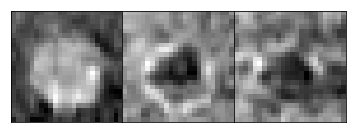

In [96]:
for cls in C.classes_to_include:
    x_test_quick = orig_data_dict[cls][0][np.where(orig_data_dict[cls][1] == indices_f[test_ix])]
    if len(x_test_quick) > 0:
        break
hf.draw_slices(x_test_quick[0])

@njit
def update_stdevs(mu, m, sigma, s, z_states, filter_results, p_z_x):
    sigma_est = np.empty([num_features, num_units])
    s_est = np.empty([num_units])
    var_adj = np.zeros([num_states])
    a_i = np.zeros([num_states])
    c_i = np.zeros([num_states])

    for u_ix in range(num_units):
        for state_ix in range(num_states):
            a_i[state_ix] = sum([p_z_x[img_ix, state_ix] * (filter_results[img_ix, u_ix] - \
                       np.dot(mu[:, u_ix], z_states_bool[state_ix]) - m[u_ix])**2 for img_ix in range(num_imgs)]) / 2
            c_i[state_ix] = sum(p_z_x[:, state_ix])

        temp = scipy.optimize.minimize(\
                    lambda Var: sum([a_i[state_ix] / (sum(np.where(z_states_bool[state_ix],
                       Var[:-1], 0))+Var[-1]) + c_i[state_ix] * log(sqrt(sum(np.where(z_states_bool[state_ix],
                       Var[:-1], 0))+Var[-1]) * sqrt(2*pi)) for state_ix in range(num_states)]),
                      np.concatenate([sigma[:, u_ix]**2, [s[u_ix]**2]]), 
                      bounds=tuple(itertools.repeat((.001, 1000),num_features+1)))

        sigma_est[:, u_ix] = [sqrt(i) for i in temp['x'][:-1]]
        s_est[u_ix] = sqrt(temp['x'][-1])
    
    return sigma_est, s_est

t=time.time()
for f_ix in range(num_features):
    state_indices = [state_ix for state_ix in range(num_states) if z_states_bool[state_ix][f_ix]]
    #p_z_x does not need to be rescaled because the factor cancels out
    var_adj = np.zeros([num_states])
    a_i = np.zeros([num_states])
    c_i = np.zeros([num_states])
    
    for u_ix in range(num_units):
        for state_ix in state_indices:
            z = z_states[state_ix]

            mean = np.dot(mu[:, u_ix], z) + m[u_ix]
            var_adj[state_ix] = sum(np.where(z==1, sigma[:, u_ix]**2, 0)) + s[u_ix]**2 - sigma[f_ix, u_ix]**2
            
            a_i[state_ix] = sum([p_z_x[img_ix, state_ix] * (filter_results[img_ix, u_ix] - mean)**2 for img_ix in range(num_imgs)])
            c_i[state_ix] = sum(p_z_x[:, state_ix])
        
        sigma_est[f_ix, u_ix] = sqrt(scipy.optimize.fsolve(lambda x: sum([a_i[state_ix]/(x+var_adj[state_ix])**2 - \
                                         c_i[state_ix]/(x+var_adj[state_ix]) for state_ix in state_indices]), \
                                          sigma[f_ix, u_ix]))
        
        if u_ix % 20 == 0:
            print(f_ix, u_ix, time.time()-t)

t=time.time()
#state_indices = [state_ix for state_ix in range(num_states) if z_states_bool[state_ix][f_ix]]
#p_z_x does not need to be rescaled because the factor cancels out
var_adj = np.zeros([num_states])
a_i = np.zeros([num_states])
c_i = np.zeros([num_states])

for u_ix in range(num_units):
    for state_ix in range(num_states):
        mean = np.dot(mu[:, u_ix], z_states[state_ix]) + m[u_ix]
        a_i[state_ix] = sum([p_z_x[img_ix, state_ix] * (filter_results[img_ix, u_ix] - mean)**2 for img_ix in range(num_imgs)])
        c_i[state_ix] = sum(p_z_x[:, state_ix])

    temp = scipy.optimize.linearmixing(\
                lambda Var: sum([a_i[state_ix]/(sum(np.where(z_states[state_ix]==1, Var[:-1]**2, 0))+Var[-1]**2)**2 - \
                 c_i[state_ix]/(sum(np.where(z_states[state_ix]==1, Var[:-1]**2, 0))+Var[-1]**2) for state_ix in range(num_states)]), \
                  np.concatenate([sigma[:, u_ix], [s[u_ix]]]), verbose=True, maxiter=10000)
    
    #sigma_est[:, u_ix]
    if u_ix % 20 == 0:
        print(u_ix, time.time()-t)
    break

t=time.time()
for f_ix in range(num_features):
    state_indices = [state_ix for state_ix in range(num_states) if z_states_bool[state_ix][f_ix]]
    #p_z_x does not need to be rescaled because the factor cancels out
    var_adj = np.zeros([num_states])
    a_i = np.zeros([num_states])
    c_i = np.zeros([num_states])
    
    for u_ix in range(num_units):
        for state_ix in state_indices:
            z = z_states[state_ix]

            mean = np.dot(mu[:, u_ix], z) + m[u_ix]
            var_adj[state_ix] = sum(np.where(z==1, sigma[:, u_ix]**2, 0)) + s[u_ix]**2 - sigma[f_ix, u_ix]**2
            
            a_i[state_ix] = sum([p_z_x[img_ix, state_ix] * (filter_results[img_ix, u_ix] - mean)**2 for img_ix in range(num_imgs)])
            c_i[state_ix] = sum(p_z_x[:, state_ix])
        
        sigma_est[f_ix, u_ix] = sqrt(scipy.optimize.fsolve(lambda x: sum([(a_i[state_ix]/(x+var_adj[state_ix]) - \
                                         c_i[state_ix])/(x+var_adj[state_ix]) for state_ix in state_indices]), \
                                          sigma[f_ix, u_ix]))
        
        if u_ix % 20 == 0:
            print(f_ix, u_ix, time.time()-t)

header = ['filter_num']
for cls in C.classes_to_include:
    header += [f+"_"+cls for f in features_by_cls[cls]]

with open('E:\\feature_filters.csv', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(header)
    for f_num in range(100):
        writer.writerow([f_num] + [feature_filters[f][f_num] for cls in features for f in features_by_cls[cls]])

In [98]:
Z_test_features = ['E106097391_0', 'E104978772_1', '12900535_0', 'E100150242_0', 'E105490014_0', 'E103147618_0', 'E103510187_0', 'E104657225_0', 'E100551966_0', 'E101388602_0', 'E100215900_8', 'E100215900_7', 'E104045692_0', '13104521_0', 'E100383453_0', '12943286_0', '12271995_0', 'E102315724_0', 'E104949189_0', 'E100511083_1', 'E101579471_0', '13018986_1', '13203550_8', '13112385_0', '12712463_0', '12361082_0', '13028374_0', 'E103985934_1', 'E100529980_0', '12042703_3', '12961059_0', 'E105724706_2', 'E100592424_2', 'E103104254_0', 'E104546069_0', 'E101665217_1', '12090000_0', 'E100592424_1', '12961059_1', 'E105474285_0', '12502068_1', 'E100814791_0', 'E102613189_0', 'E105427046_0', 'E102881031_1', 'E102929168_0', 'E102310482_0', 'E102095465_0', 'E101811299_0', 'E104737273_0', '12890053_0', 'E100168661_1', '12637865_0', 'E100168661_2', '12239783_0', '12707781_0', '12706568_1', '12823036_0', '12404081_0', '12365693_1']

x_test = {cls: orig_data_dict[cls][0][np.where(np.isin(orig_data_dict[cls][1], Z_test_features))] for cls in C.classes_to_include}
Z_test = {cls: orig_data_dict[cls][1][np.where(np.isin(orig_data_dict[cls][1], Z_test_features))] for cls in C.classes_to_include}

In [ ]:
# Least squares approach
Theta = np.array([feature_filter_means[f] for f in all_features])
Theta = np.transpose(Theta, (1,0))

filters_test = {}
features_test = {}
for cls in C.classes_to_include:
    filters_test[cls] = model_dense_outputs.predict(x_test[cls], verbose=False)
    filters_test[cls] = (filters_test[cls] - filter_avgs) / filter_stds
    features_test[cls] = np.linalg.lstsq(Theta, np.transpose(filters_test[cls], (1,0)))[0]
    #filters_test[cls] = np.apply_along_axis(lambda x: x / filter_avgs, 1, filters_test[cls])

In [33]:
from sklearn.decomposition import FactorAnalysis

In [99]:
fa = FactorAnalysis(10)

In [36]:
filter_results.shape

(637, 100)

In [87]:
def covar_to_corr(covar):
    A = np.diag(np.diag(covar)**(-0.5))
    return np.matmul(np.matmul(A, covar), A)

In [90]:
corr = covar_to_corr(dummy_fa.get_covariance())

In [ ]:
np.linalg.eigvals(corr - np.linalg.pinv(np.diag(np.diag(np.linalg.pinv(corr)))))

In [ ]:
def get_cutoff_eigenval()

In [65]:
dummy = np.random.normal(size=filter_results.shape)
dummy_fa = FactorAnalysis()
dummy_fa.fit(dummy)

FactorAnalysis(copy=True, iterated_power=3, max_iter=1000, n_components=None,
        noise_variance_init=None, random_state=0, svd_method='randomized',
        tol=0.01)

In [ ]:
np.linalg.eigvals(dummy_fa.get_covariance())

In [101]:
sum(np.linalg.eigvals(fa.get_covariance()) > np.mean(np.linalg.eigvals(dummy_fa.get_covariance())))

8

In [100]:
fa.fit(filter_results)

FactorAnalysis(copy=True, iterated_power=3, max_iter=1000, n_components=10,
        noise_variance_init=None, random_state=0, svd_method='randomized',
        tol=0.01)

In [ ]:
np.linalg.eigvals()

In [53]:
x=3
fa.get_covariance()[x,x] - fa.noise_variance_[x]

0.89081373261106078

cls = "colorectal"
x_test_quick = orig_data_dict[cls][0][np.where(orig_data_dict[cls][1] == "E105724706_2.npy")]
x_test_quick = orig_data_dict["fnh"][0][np.where(orig_data_dict["fnh"][1] == "E104189184_0.npy")]
filters_quick = model_dense_outputs.predict(x_test_quick, verbose=False)

In [ ]:
img_num = 0
evidence = {}

for f in all_features:
    evidence[f + "/" + str(cls_features[f])] = cnna.get_evidence_strength(feature_filters[f], filters_quick[0])#filters_test[true_cls][img_num])
    #max_strength = max(max_strength, evidence[f + "/" + str(cls_features[f])])

#for f in evidence:
#    evidence[f] /= max_strength
print("Detected features:")
for f,strength in sorted(evidence.items(), key=lambda x:x[1], reverse=True)[:5]:
    #if strength > 1:
    print("- " + f, "- %d%%" % (strength*100))

hf.plot_section_auto(x_test_quick[0])#[true_cls][img_num])

In [101]:
output = {}
for cls in C.classes_to_include:
    for img_num in range(len(filters_test[cls])):
        z = Z_test[cls][img_num]
        x = np.expand_dims(x_test[cls][img_num], axis=0)
        evidence = {}
        
        output[z] = [cls]
        
        preds = model.predict(x, verbose=False)[0]
        for pred_cls, pred_conf in sorted(zip(C.classes_to_include, preds), key=lambda x:x[1], reverse=True)[:2]:
            output[z] = output[z] + [pred_cls]
        
        #for f in all_features:
        #    evidence[f + "/" + str(cls_features[f])] = get_evidence_strength(feature_filters[f], filters_test[cls][img_num])
        
        for i in range(len(all_features)):
            evidence[all_features[i] + "/" + str(cls_features[all_features[i]])] = features_test[cls][i, img_num]
        
        f1='infiltrative'
        f2='lobulated margins'
        if evidence[f1 + "/" + str(cls_features[f1])] < evidence[f2 + "/" + str(cls_features[f2])]:
            evidence.pop(f1 + "/" + str(cls_features[f1]))
        else:
            evidence.pop(f2 + "/" + str(cls_features[f2]))
        
        for f,strength in sorted(evidence.items(), key=lambda x:x[1], reverse=True):
            output[z] = output[z] + [f, strength]

In [104]:
with open('E:\\filters_pred5.csv', 'w', newline='') as csvfile:
    header = ['img_fn', 'agreement1', 'agreement2', 'true_cls', 'pred_cls1', 'pred_cls2'] + \
            [s for i in range(len(all_features)) for s in ['feature_%d' % i,'strength_%d' % i]]
    writer = csv.writer(csvfile)
    writer.writerow(header)
    for z_num in range(len(Z_test_features)):
        writer.writerow([Z_test_features[z_num]] + [output[Z_test_features[z_num]][0] in output[Z_test_features[z_num]][3], \
                        output[Z_test_features[z_num]][0] in output[Z_test_features[z_num]][5]] + output[Z_test_features[z_num]])

In [60]:
df = pd.read_excel("E:\\filters_pred3.xlsx")

In [75]:
agree = 0
for _,row in df.iterrows():
    if row["pred_cls1"] in row["feature_1"]:
        agree += 1
print(agree/60)

52
